# **Agents Estimation and AQI prediction**

After finding the best model for each agent, use them to compute the complessive pollution estimatins and compute AQI values.

## Notebook Setup

In [1]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

from utils import *

datasets_folder = './datasets'
verbosity = 0
figsize = (18,4)

tf.config.set_visible_devices([], 'GPU')
print(tf.config.list_physical_devices('GPU'))

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [2]:
pollution_data = read_and_preprocess_dataset(datasets_folder, 'pollution', v=verbosity)
traffic_data = read_and_preprocess_dataset(datasets_folder, 'traffic', v=verbosity, radius=2)
weather_data = read_and_preprocess_dataset(datasets_folder, 'weather', v=verbosity)

stations = pollution_data.keys()

In [3]:
station_data = {}
date_encoding = 'radial_months-sin-cos_days_hours'

for station in stations:
    station_data[station] = prepare_station_data_for_training(
        pollution_data[station], 
        traffic_data[station], 
        weather_data, 
        encoding_method=date_encoding,
        # weather merging parameters:
        aggregations = DEFAULT_AGGREGATIONS,
        max_min_columns = DEFAULT_MAX_MIN_COLUMNS, 
        # traffic merging parameters:
        bin_size = 3,
        offset = 0
        # bin_size = 8,
        # offset = 2
    )
    
    print(f'Station {station} agents: ',', '.join(list(station_data[station].keys())))

n_hour_features = len(station_data['GIARDINI MARGHERITA']['NO2'].columns) - 1 # -1 because Agent_value is the target
n_daily_features = len(station_data['GIARDINI MARGHERITA']['PM2.5'].columns) - 1 # -1 because Agent_value is the target

Station GIARDINI MARGHERITA agents:  NO2, O3, PM10, PM2.5
Station PORTA SAN FELICE agents:  C6H6, CO, NO2, PM10, PM2.5
Station VIA CHIARINI agents:  NO2, O3, PM10


In [4]:
train_split_date = datetime(2023,12,31,23)
target = 'Agent_value'

In [5]:
training_sets = {}
test_sets = {}

for station in stations:
    training_sets[station] = {}
    test_sets[station] = {}
    for agent in station_data[station].keys():
        training_sets[station][agent] = {}
        test_sets[station][agent] = {}

        x_train, y_train, x_test, y_test = create_train_test(station_data[station][agent], train_split_date, y=target)

        training_sets[station][agent]['x'] = x_train
        training_sets[station][agent]['y'] = y_train
        test_sets[station][agent]['x'] = x_test
        test_sets[station][agent]['y'] = y_test

## Agents Estimations

Prepare a dictionary containing the model to use for each agent of each station

### **Hourly models**

#### LSTM

In [ ]:
lstm_params = {
    'time_steps': 3,
    'n_features': n_hour_features,
    'lstm_units': 128,
    'optimizer': Adam(learning_rate=1e-3),
    'loss': 'mean_absolute_error',
    'use_mask': True
}

lstm_train_params = {
    'epochs': 20,
    'batch_size': 64,
}

lstm = ('LSTM-masked', build_lstm_model, lstm_params, lstm_train_params, True)

In [ ]:
lstm2_params = {
    'time_steps': 5,
    'n_features': n_hour_features,
    'lstm_units': [64, 32],
    'optimizer': Adam(learning_rate=1e-3),
    'loss': 'mean_squared_error',
    'use_mask': True
}

lstm2_train_params = {
    'epochs': 20,
    'batch_size': 32,
}

lstm2 = ('LSTM_2-masked', build_lstm_model, lstm2_params, lstm2_train_params, True)

#### FFNN

In [ ]:
ffnn_params = {
    'input_size': n_hour_features,
    'neurons': [1024, 512, 256, 128],
    'dropout': 0.2,
    'optimizer': Adam(learning_rate=1e-2),
    'loss': 'mean_absolute_error'
}

ffnn_train_params = {
    'epochs': 10,
    'batch_size': 32,
}

FFNN = ('Feed Forward NN', build_ffnn_model, ffnn_params, ffnn_train_params, False)

#### 1D Convolution

In [ ]:
conv_params = {
    'time_steps': 8,
    'n_features': n_hour_features,
    'filters': 64,
    'optimizer': Adam(learning_rate=3e-3),
    'loss': 'mean_absolute_error'
}

conv_train_params = {
    'epochs': 10,
    'batch_size': 64,
}

conv1d = ('Conv1D', build_conv_model, conv_params, conv_train_params, True)

### **Daily Models**

#### FFNN

In [ ]:
ffnn_daily_params = {
    'input_size': n_daily_features,
    'neurons': [1024, 512, 256, 128],
    'optimizer': Adam(learning_rate=3e-4),
    'loss': 'mean_absolute_error'
}

ffnn_daily_train_params = {
    'epochs':20,
    'batch_size':32,
}

FFNN_daily = ('Feed Forward NN', build_ffnn_model, ffnn_daily_params, ffnn_daily_train_params, False)

In [6]:
xgbr_params = {
    'learning_rate': 0.05,
    'max_depth': 4,
    'n_estimators': 100,
    'subsample': 0.8,
    'random_state': 42,
}

xgb = ('XGB Regressor', xgboost.XGBRegressor, xgbr_params, None, False)

### training

In [ ]:
# models = {
#     'GIARDINI MARGHERITA':{
#         'NO2': lstm, 
#         'O3': xgb, # LSTM_old, 
#         'PM10':FFNN_daily,
#         'PM2.5':FFNN_daily 
#     },
#     'PORTA SAN FELICE':{
#         'C6H6': lstm, 
#         'CO': FFNN, 
#         'NO2': conv1d,
#         'PM10':FFNN_daily,  
#         'PM2.5':FFNN_daily 
#     },
#     'VIA CHIARINI':{
#         'NO2': FFNN, 
#         'O3': lstm2, 
#         'PM10':FFNN_daily  
#     }
# }
models = {
    'GIARDINI MARGHERITA':{
        'NO2': xgb, 
        'O3': xgb, # LSTM_old, 
        'PM10':FFNN_daily,
        'PM2.5':FFNN_daily 
    },
    'PORTA SAN FELICE':{
        'C6H6': xgb, 
        'CO': xgb, 
        'NO2': xgb,
        'PM10':FFNN_daily,  
        'PM2.5':FFNN_daily 
    },
    'VIA CHIARINI':{
        'NO2': xgb, 
        'O3': xgb, 
        'PM10':FFNN_daily  
    }
}

In [10]:
agents_predictions = train_agents(models, training_sets, test_sets)

Predicting NO2 in GIARDINI MARGHERITA using XGB Regressor...
Predicting O3 in GIARDINI MARGHERITA using XGB Regressor...
Predicting PM10 in GIARDINI MARGHERITA using Feed Forward NN...
Predicting PM2.5 in GIARDINI MARGHERITA using Feed Forward NN...
Predicting C6H6 in PORTA SAN FELICE using XGB Regressor...
Predicting CO in PORTA SAN FELICE using XGB Regressor...
Predicting NO2 in PORTA SAN FELICE using XGB Regressor...
Predicting PM10 in PORTA SAN FELICE using Feed Forward NN...
Predicting PM2.5 in PORTA SAN FELICE using Feed Forward NN...
Predicting NO2 in VIA CHIARINI using XGB Regressor...
Predicting O3 in VIA CHIARINI using XGB Regressor...
Predicting PM10 in VIA CHIARINI using Feed Forward NN...


## AQI calculation

In [11]:
pred_AQIs_daily = {
    s: {agent: get_AQI(agents_predictions[s][agent], 
                        agent=agent, 
                        period='day', 
                        value_column='Agent_value',
                        ) for agent in agents_predictions[s].keys()} for s in agents_predictions
}

pred_AQI_daily = merge_AQIs(pred_AQIs_daily, period='day')

pred_AQIs_hourly = {
    s: {agent: get_AQI(agents_predictions[s][agent],
                       agent=agent,
                       period='hour', 
                       value_column='Agent_value',
                       include_hourly_pm=False
                       ) for agent in agents_predictions[s].keys()} for s in agents_predictions
}

pred_AQI_hourly = merge_AQIs(pred_AQIs_hourly, period='hour')

In [12]:
true_AQIs_daily = {
    s: {agent: get_AQI(test_sets[s][agent]['y'], 
                        agent=agent, 
                        period='day', 
                        value_column='Agent_value',
                        ) for agent in test_sets[s].keys()} for s in test_sets
}

true_AQI_daily = merge_AQIs(true_AQIs_daily, period='day')

true_AQIs_hourly = {
    s: {agent: get_AQI(test_sets[s][agent]['y'],
                       agent=agent,
                       period='hour', 
                       value_column='Agent_value',
                       include_hourly_pm=False
                       ) for agent in test_sets[s].keys()} for s in test_sets
}

true_AQI_hourly = merge_AQIs(true_AQIs_hourly, period='hour')

In [13]:
AQI_diff_daily = {}
AQI_diff_hourly = {}    

for station in true_AQI_hourly:
    AQI_diff_daily[station] = AQI_difference(pred_AQI_daily[station], true_AQI_daily[station])
    AQI_diff_hourly[station] = AQI_difference(pred_AQI_hourly[station], true_AQI_hourly[station])

## AQI Comparison

In [14]:
categories = {
    'Good': 0,
    'Moderate': 50,
    'Poor': 100,
    'Very Poor': 150,
    'Severe': 200,
}
# categories = {
#     'Good': 0,
#     'Moderate': 33,
#     'Poor': 66,
#     'Very Poor': 99,
#     'Severe': 132,
# }

### Hourly AQI

Station GIARDINI MARGHERITA AQI:


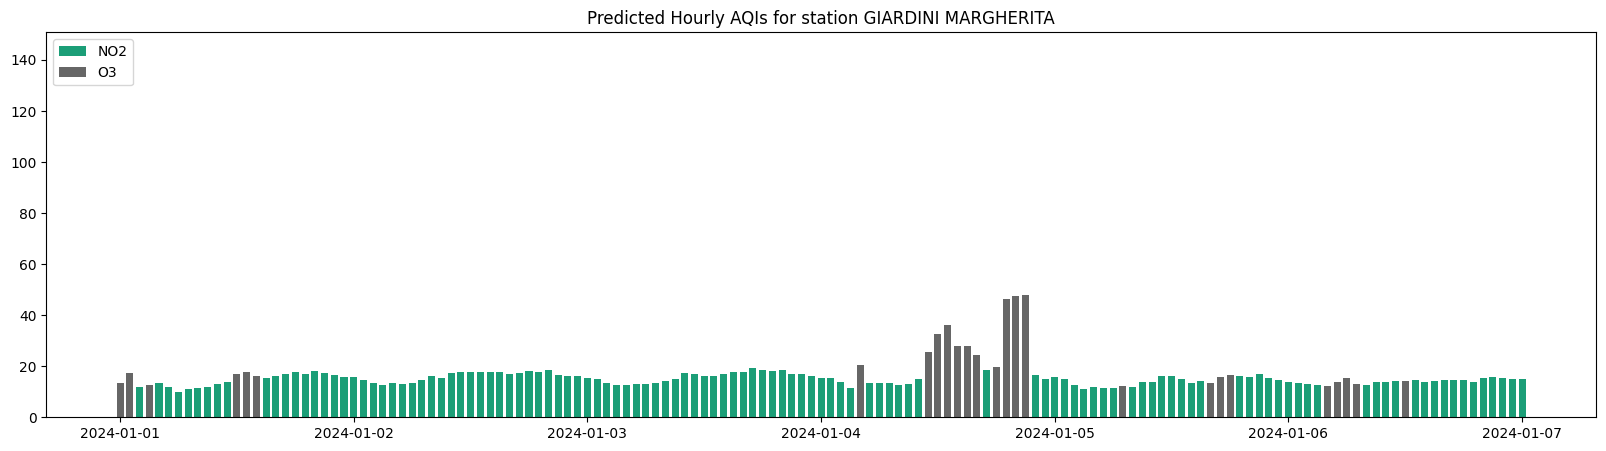

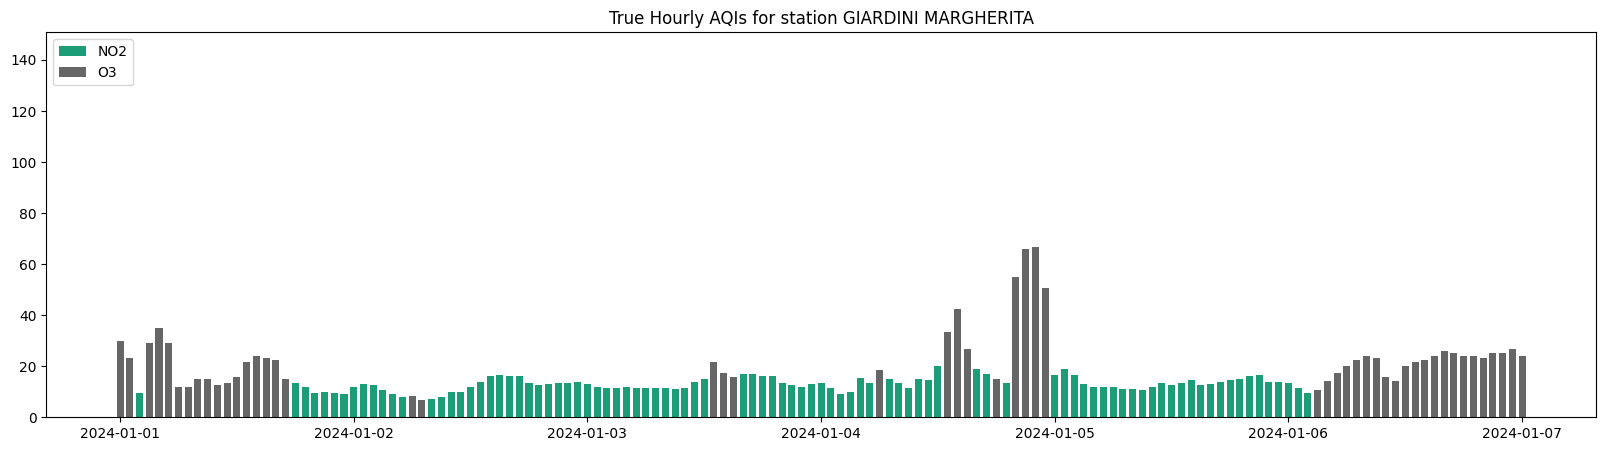

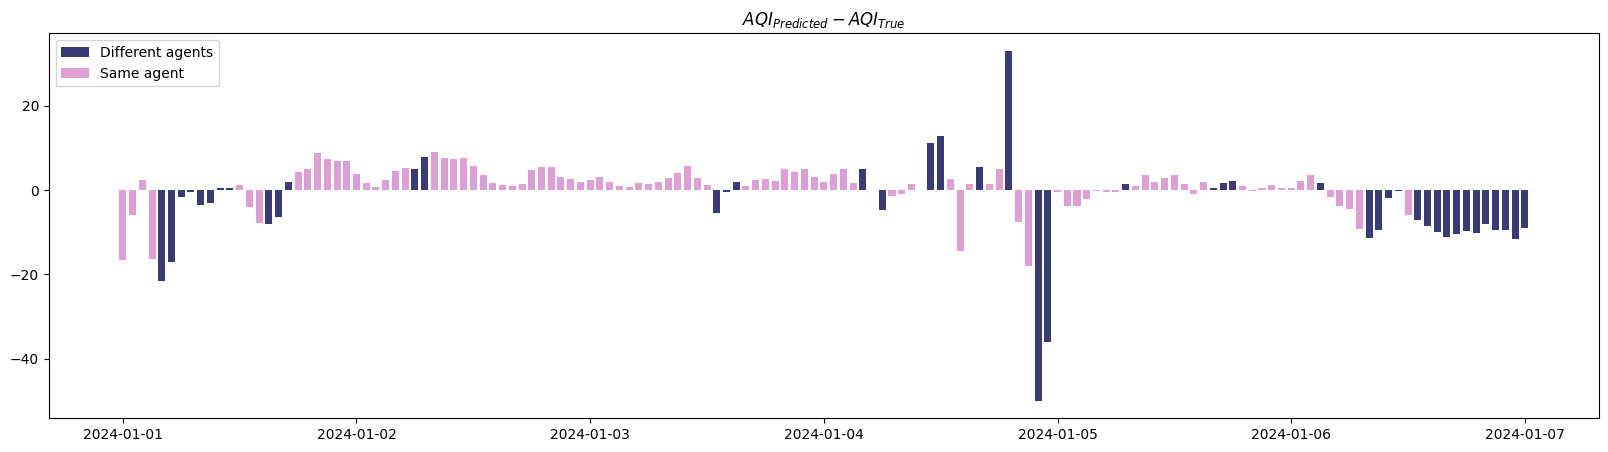

Station PORTA SAN FELICE AQI:


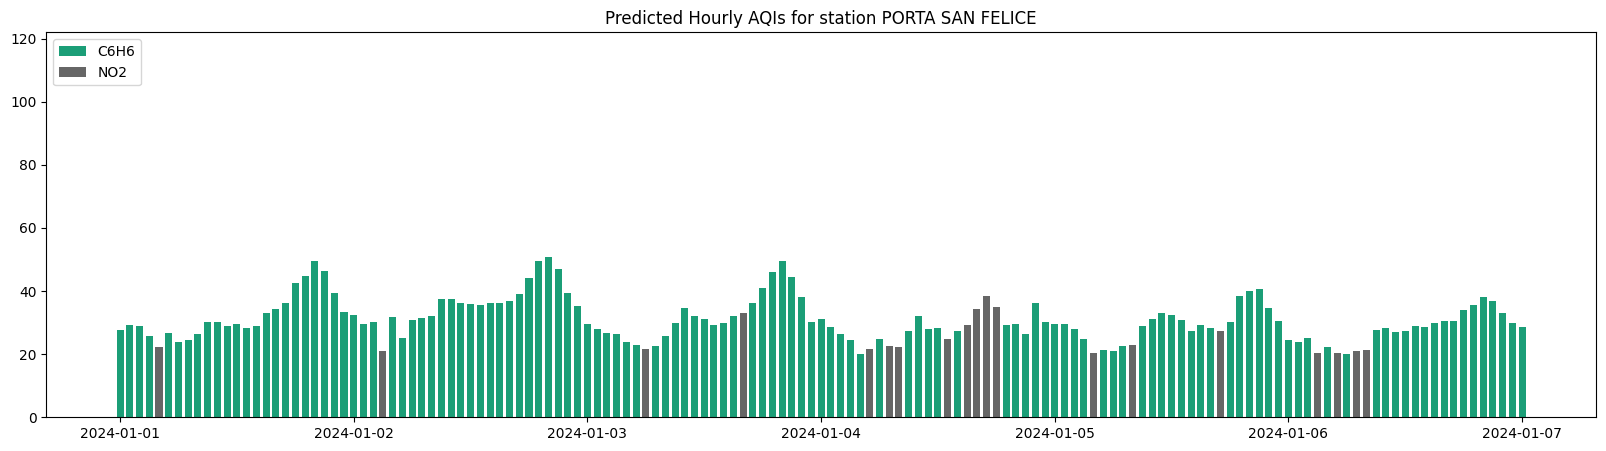

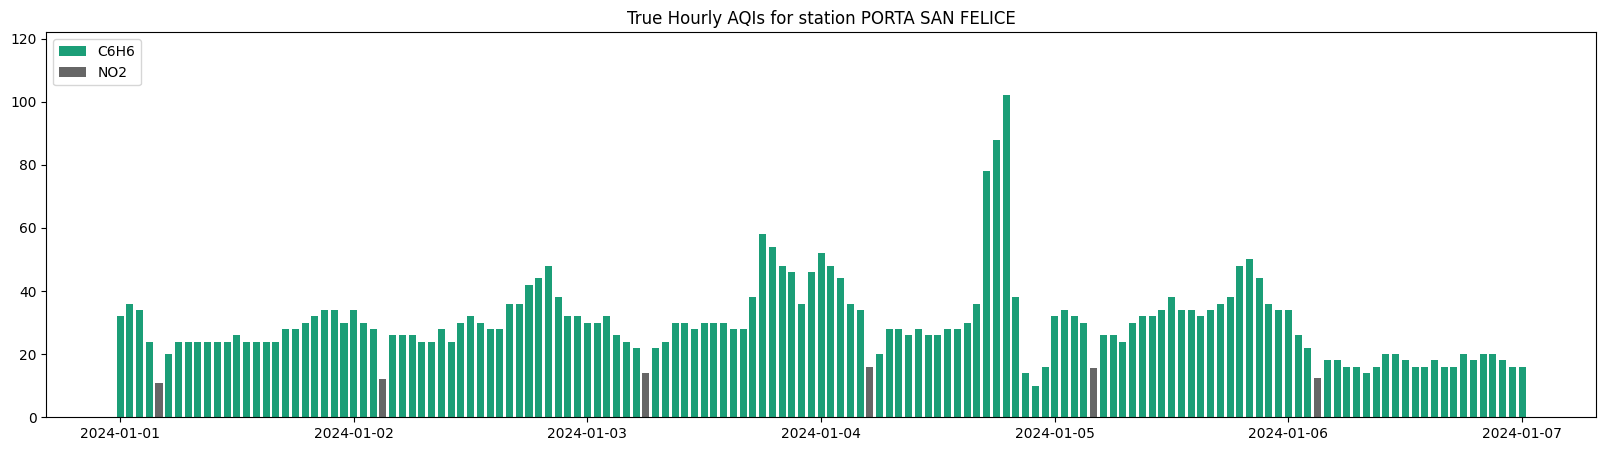

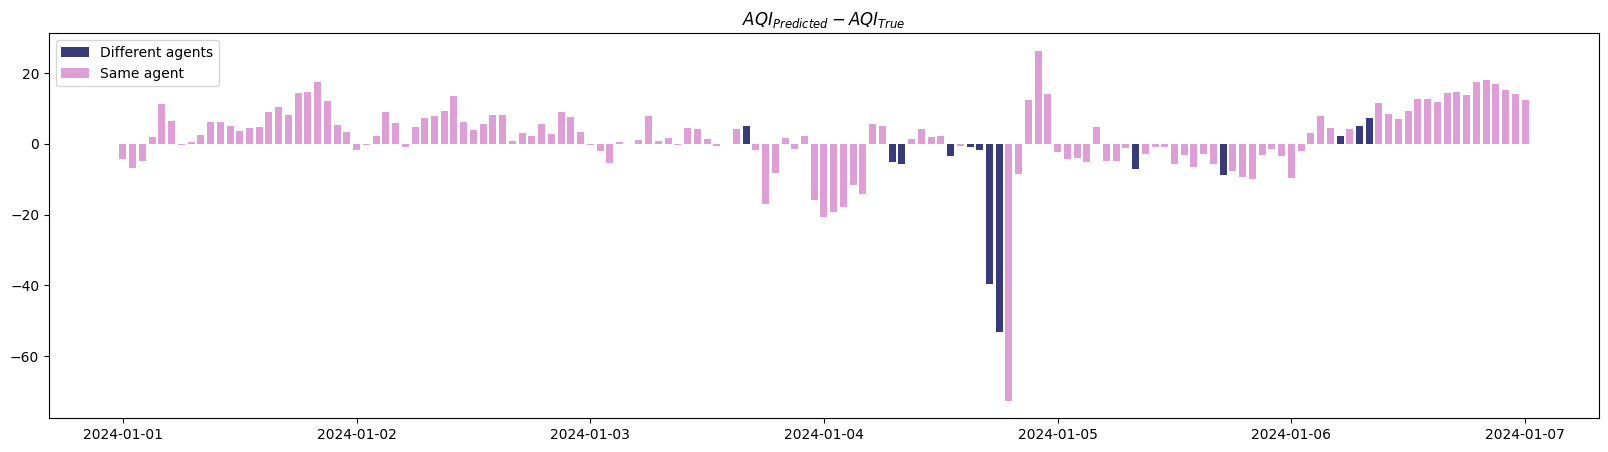

Station VIA CHIARINI AQI:


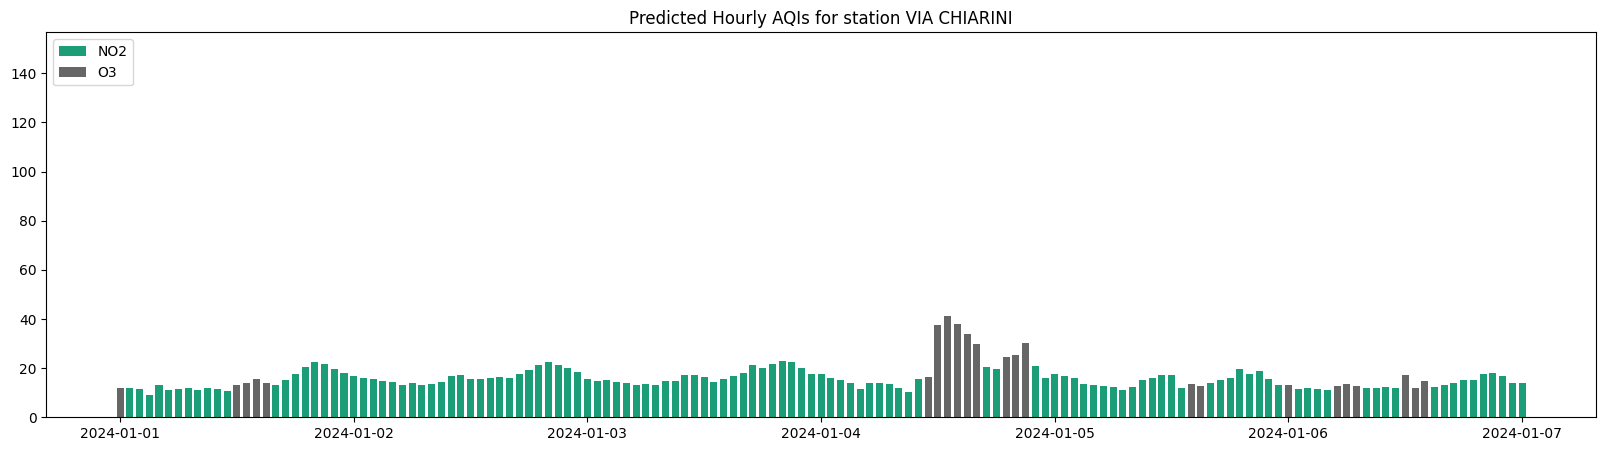

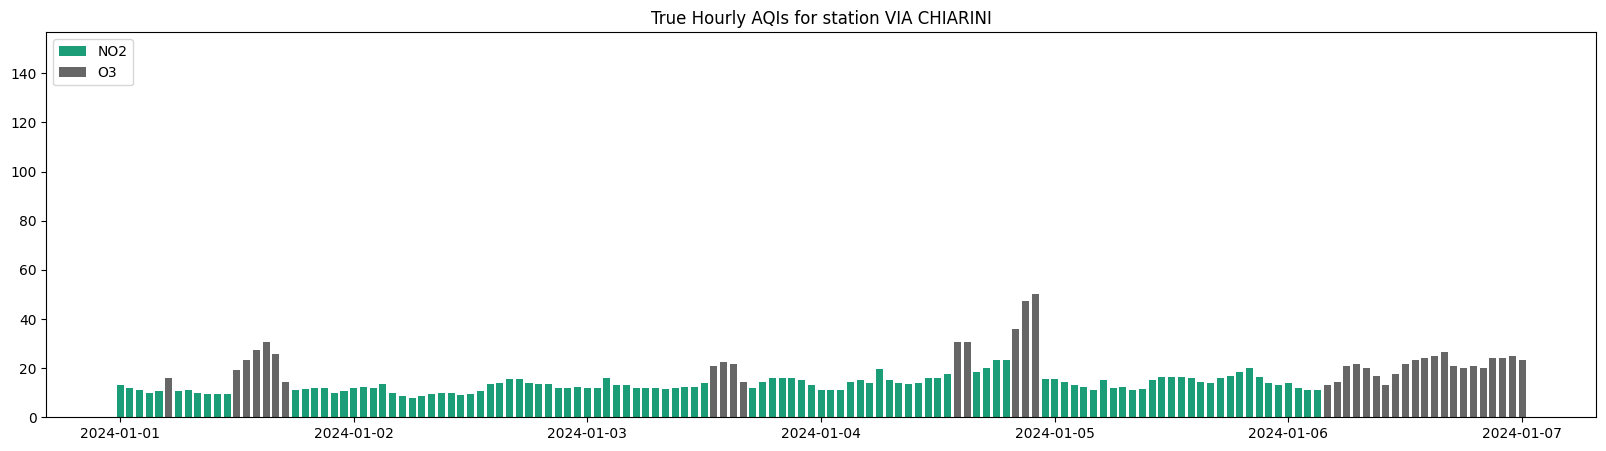

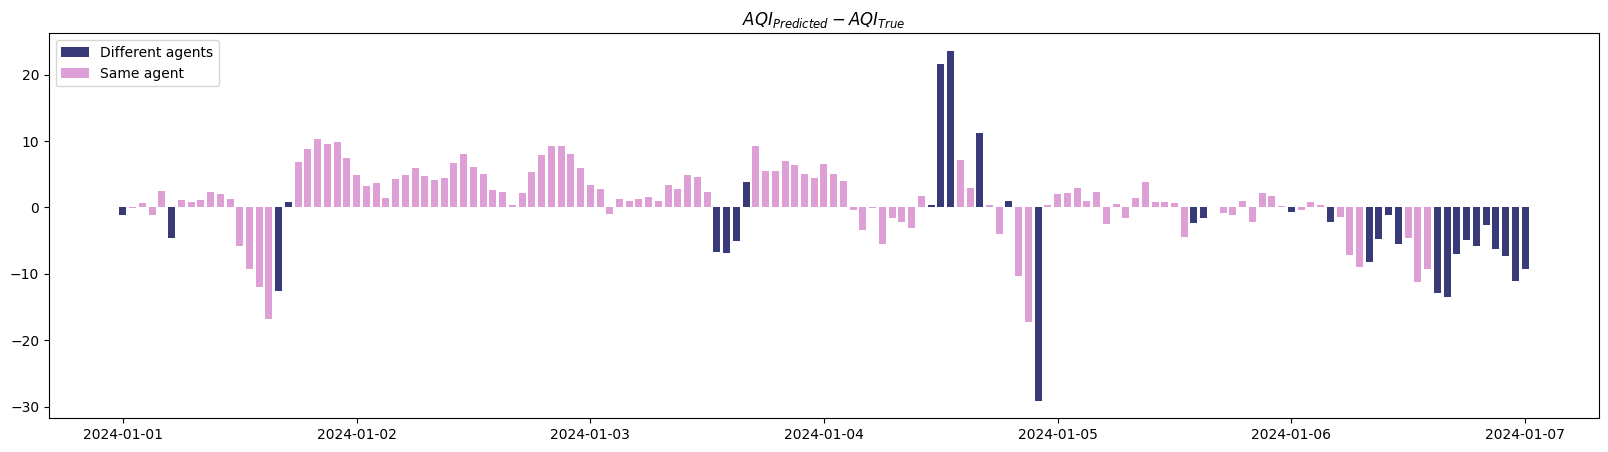

In [15]:
start=datetime(2024,1,1)
end=datetime(2024,1,7)

for station in true_AQIs_hourly:
    print(f'Station {station} AQI:')
    pred_ymax, true_ymax = pred_AQI_hourly[station]['AQI'].max(),true_AQI_hourly[station]['AQI'].max()
    ylims = [0, max(pred_ymax, true_ymax)]

    plot_AQI(
        station_AQI=[
            pred_AQI_hourly[station],
            true_AQI_hourly[station],
            AQI_diff_hourly[station]
        ], 
        title=[
            f'Predicted Hourly AQIs for station {station}',
            f'True Hourly AQIs for station {station}',
            r'$AQI_{Predicted} - AQI_{True}$'
        ],
        figsize=(20, 5), s=start, e=end, ylims=ylims)

con step di 33 e xgb veniva .78, .89., 80, con i modelli veri 76 90 80
modell veri step di 50 viene 87 97 89

Station GIARDINI MARGHERITA


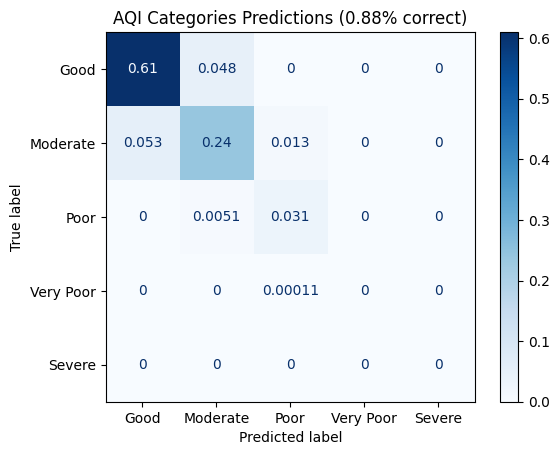

---------------------------------------------
> Absolute Mean AQI Difference: 8.41
> Positive Average AQI Difference: 7.92
> Negative Average AQI Difference: -8.93
> Percentage of Positive Differences: 51.72%
> Percentage of Negative Differences: 48.07%
> Percentage of Agent Values:
   - Same agent: 87.07
   - Different agents: 12.93


In [16]:
station = 'GIARDINI MARGHERITA'
print('=============================================')
print(f'Station {station}')
print('=============================================')
print_AQI_category_comparison(pred_AQI_hourly[station],true_AQI_hourly[station], categories=categories)
print('---------------------------------------------')
print_AQI_difference_metrics(AQI_diff_hourly[station])
print('=============================================')

Station PORTA SAN FELICE


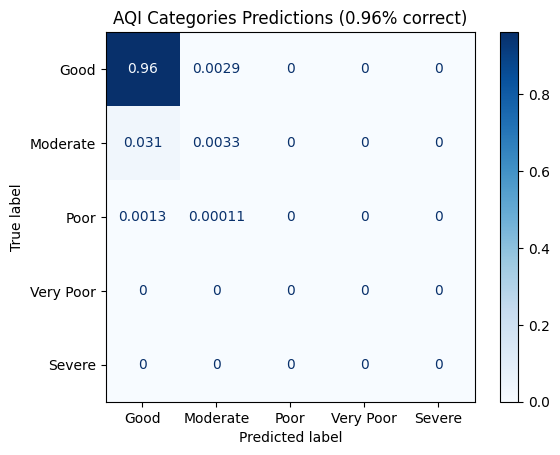

---------------------------------------------
> Absolute Mean AQI Difference: 6.62
> Positive Average AQI Difference: 6.11
> Negative Average AQI Difference: -7.61
> Percentage of Positive Differences: 66.20%
> Percentage of Negative Differences: 33.60%
> Percentage of Agent Values:
   - Same agent: 59.57
   - Different agents: 40.43


In [17]:
station = 'PORTA SAN FELICE'
print('=============================================')
print(f'Station {station}')
print('=============================================')
print_AQI_category_comparison(pred_AQI_hourly[station],true_AQI_hourly[station], categories=categories)
print('---------------------------------------------')
print_AQI_difference_metrics(AQI_diff_hourly[station])
print('=============================================')

Station VIA CHIARINI


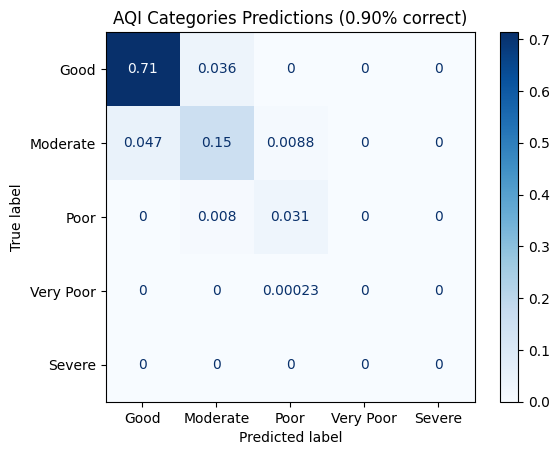

---------------------------------------------
> Absolute Mean AQI Difference: 8.26
> Positive Average AQI Difference: 8.01
> Negative Average AQI Difference: -8.62
> Percentage of Positive Differences: 57.73%
> Percentage of Negative Differences: 41.96%
> Percentage of Agent Values:
   - Same agent: 84.81
   - Different agents: 15.19


In [18]:
station = 'VIA CHIARINI'
print('=============================================')
print(f'Station {station}')
print('=============================================')
print_AQI_category_comparison(pred_AQI_hourly[station],true_AQI_hourly[station], categories=categories)
print('---------------------------------------------')
print_AQI_difference_metrics(AQI_diff_hourly[station])
print('=============================================')

### Daily AQI

Station GIARDINI MARGHERITA AQI:


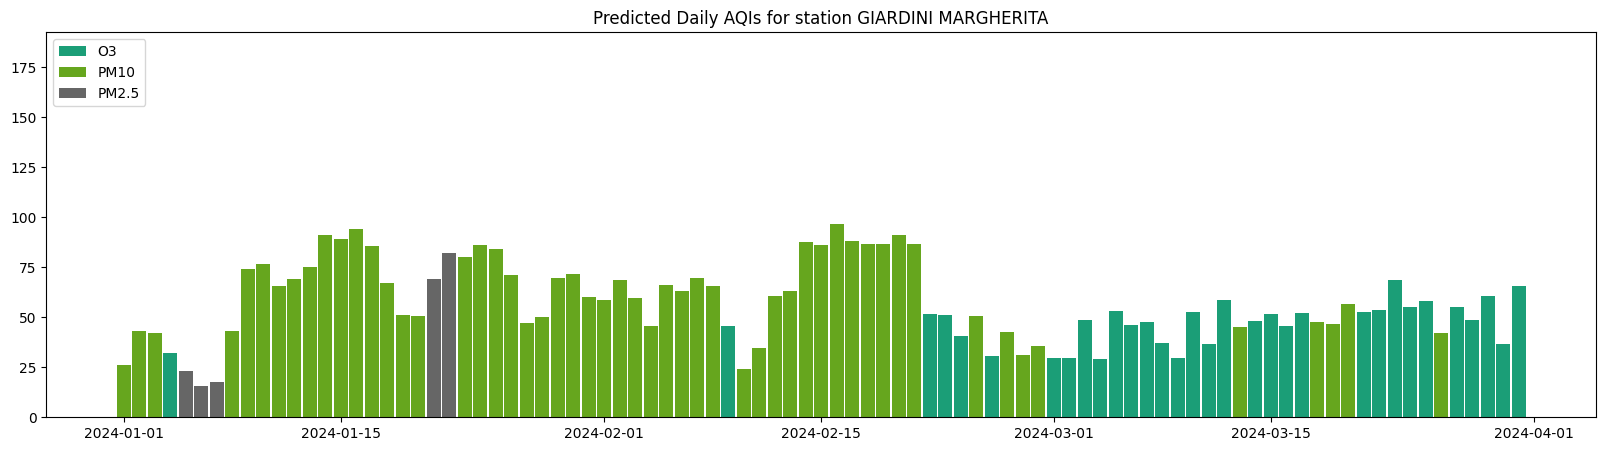

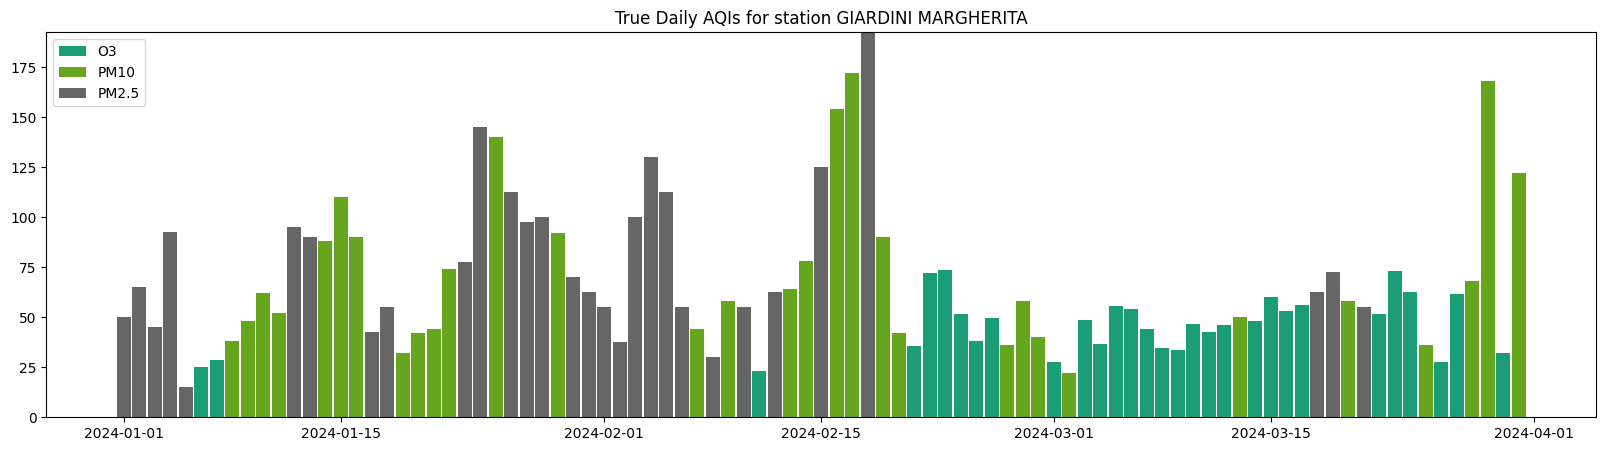

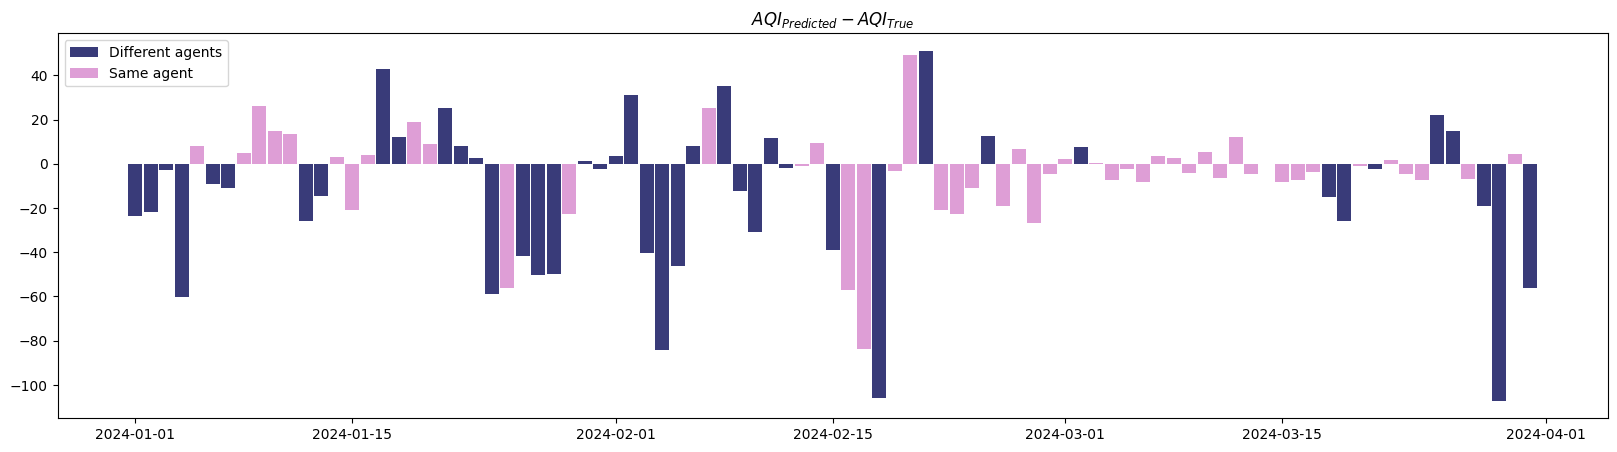

Station PORTA SAN FELICE AQI:


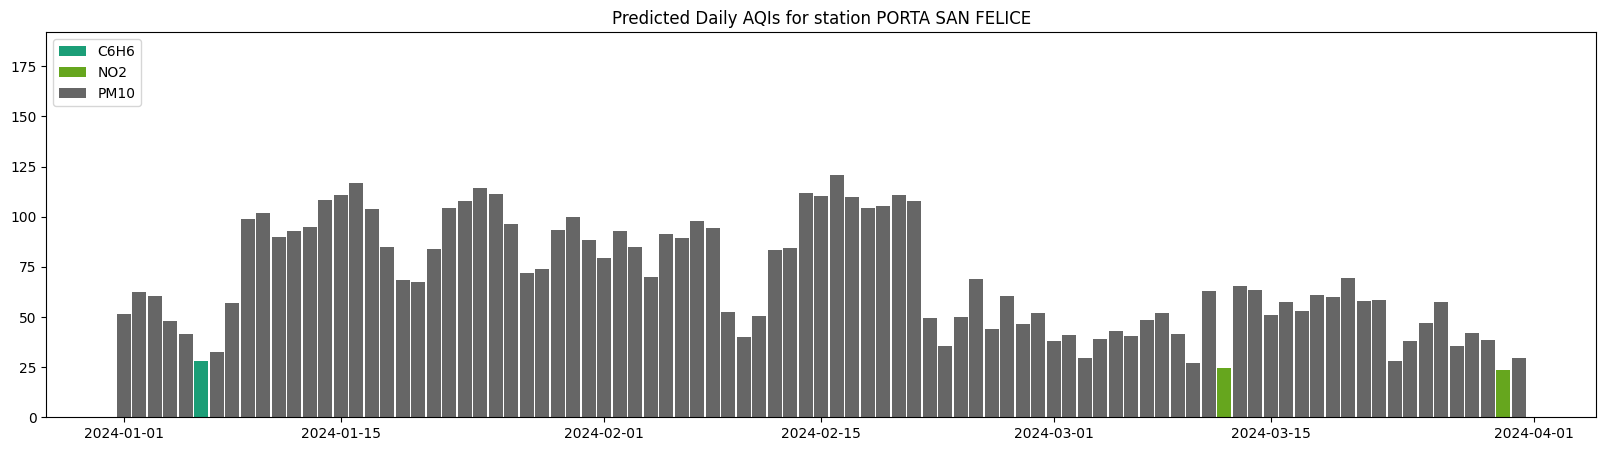

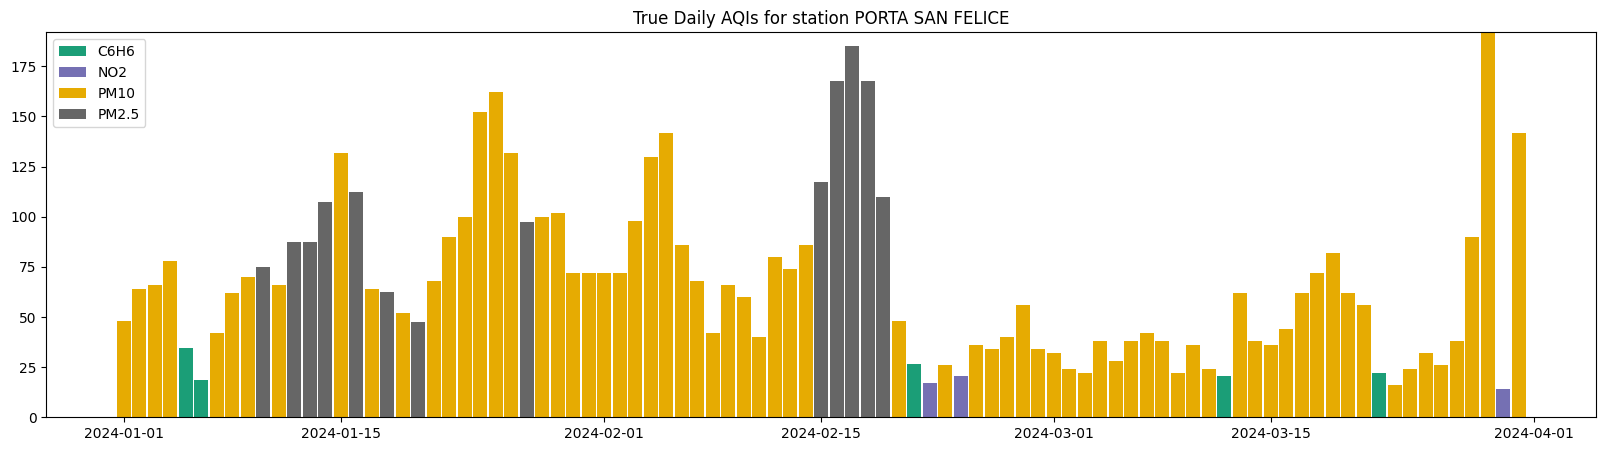

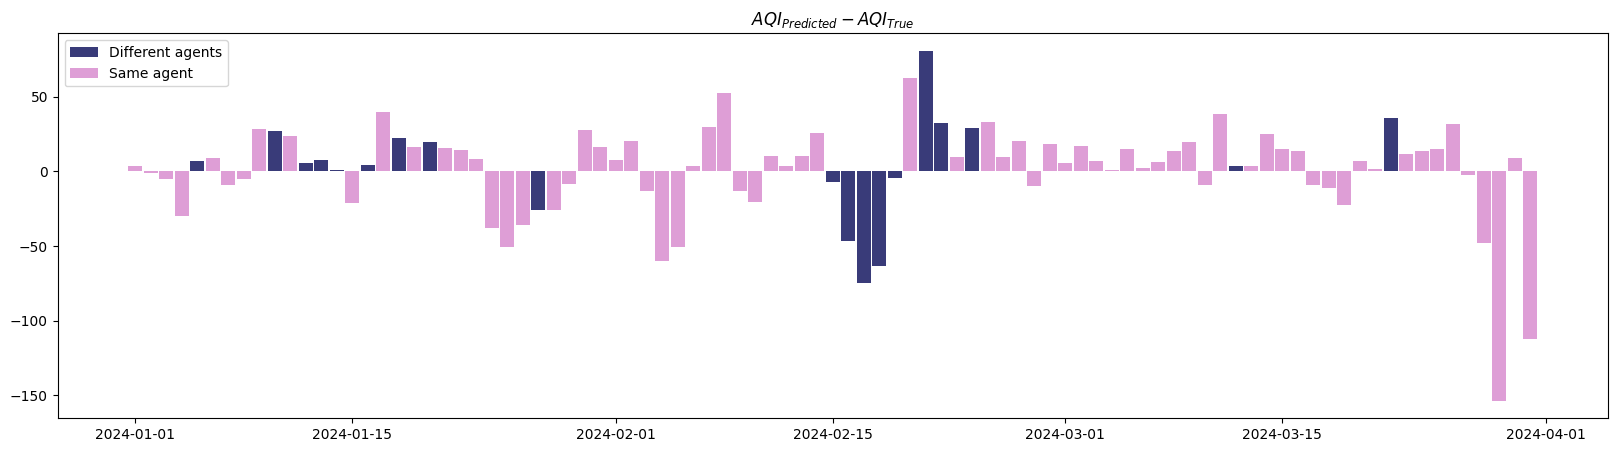

Station VIA CHIARINI AQI:


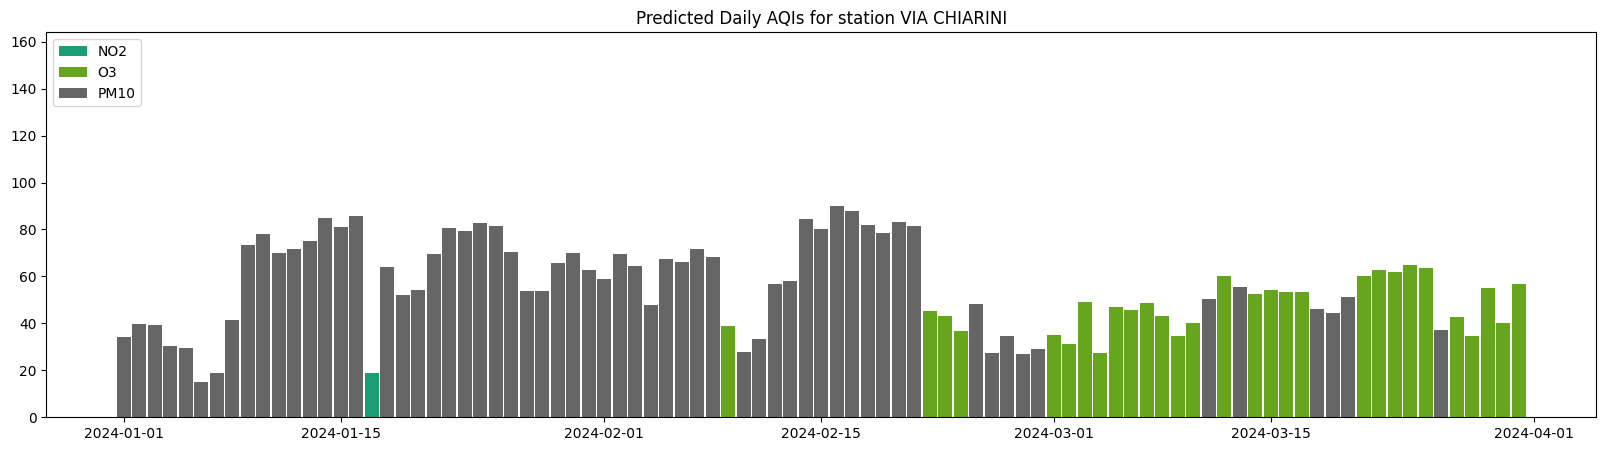

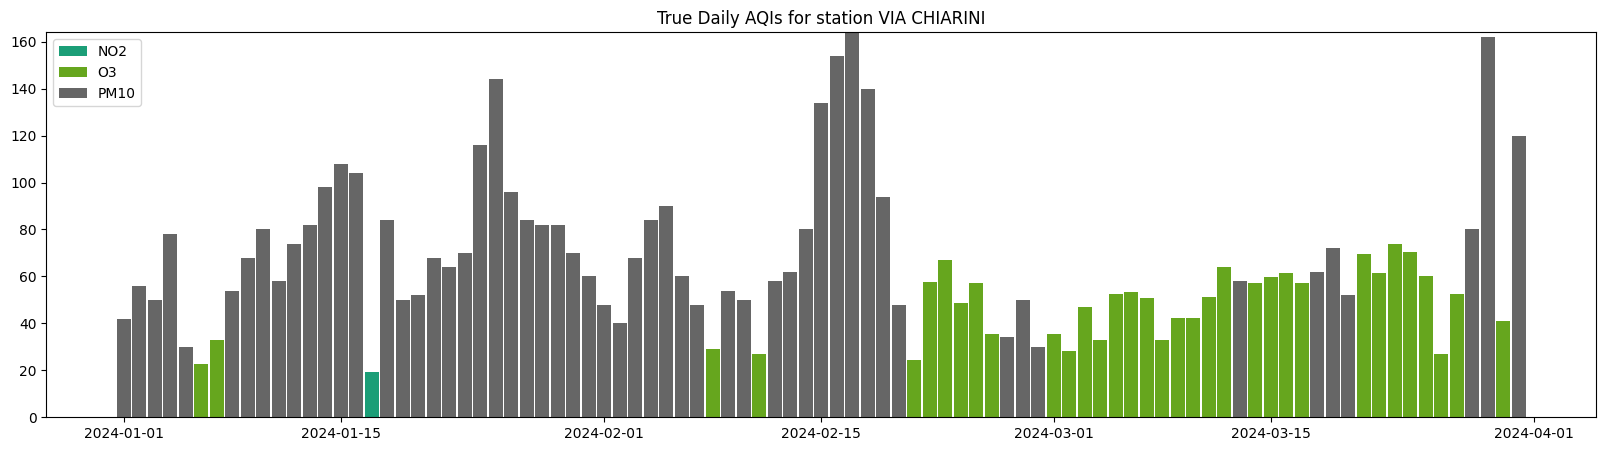

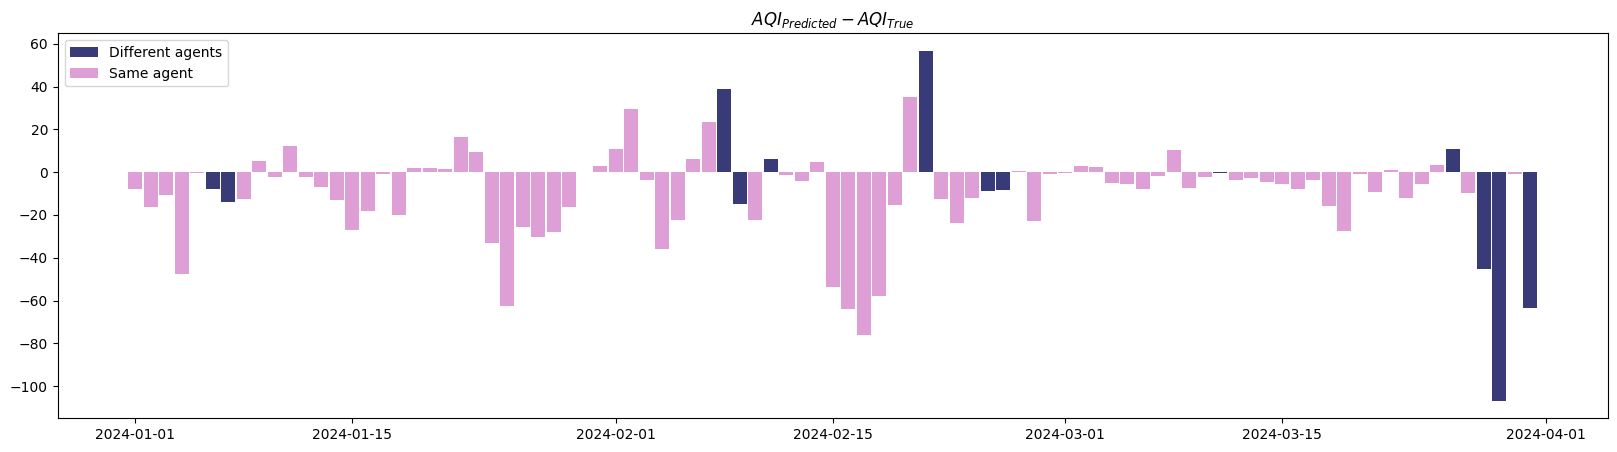

In [19]:
start=datetime(2024,1,1)
end=datetime(2024,3,31)

for station in true_AQIs_daily:
    print(f'Station {station} AQI:')
    pred_ymax, true_ymax = pred_AQI_daily[station]['AQI'].max(),true_AQI_daily[station]['AQI'].max()
    ylims = [0, max(pred_ymax, true_ymax)]

    plot_AQI(
        station_AQI=[
            pred_AQI_daily[station],
            true_AQI_daily[station],
            AQI_diff_daily[station]
        ], 
        title=[
            f'Predicted Daily AQIs for station {station}',
            f'True Daily AQIs for station {station}',
            r'$AQI_{Predicted} - AQI_{True}$'
        ], 
        figsize=(20, 5), s=start,e=end,ylims=ylims)

Station GIARDINI MARGHERITA


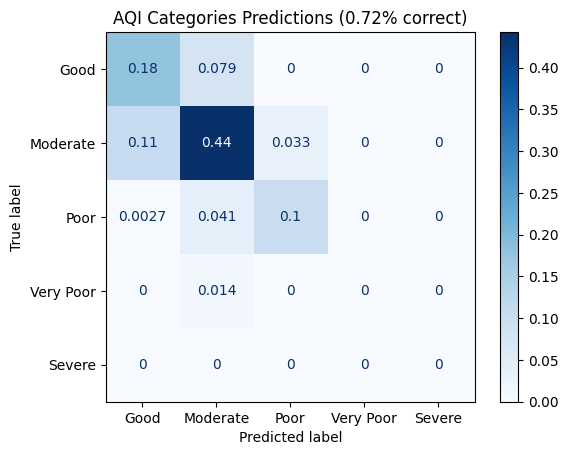

---------------------------------------------
> Absolute Mean AQI Difference: 13.51
> Positive Average AQI Difference: 10.43
> Negative Average AQI Difference: -15.85
> Percentage of Positive Differences: 43.17%
> Percentage of Negative Differences: 56.83%
> Percentage of Agent Values:
   - Same agent: 74.86
   - Different agents: 25.14


In [22]:
station = 'GIARDINI MARGHERITA'
print('=============================================')
print(f'Station {station}')
print('=============================================')
print_AQI_category_comparison(pred_AQI_daily[station],true_AQI_daily[station], categories=categories)
print('---------------------------------------------')
print_AQI_difference_metrics(AQI_diff_daily[station])
print('=============================================')

In [21]:
station = 'PORTA SAN FELICE'
print('=============================================')
print(f'Station {station}')
print('=============================================')
print_AQI_category_comparison(pred_AQI_daily[station],true_AQI_daily[station], categories=categories)
print('---------------------------------------------')
print_AQI_difference_metrics(AQI_diff_daily[station])
print('=============================================')

Station PORTA SAN FELICE


TypeError: '<' not supported between instances of 'NoneType' and 'str'

Station VIA CHIARINI


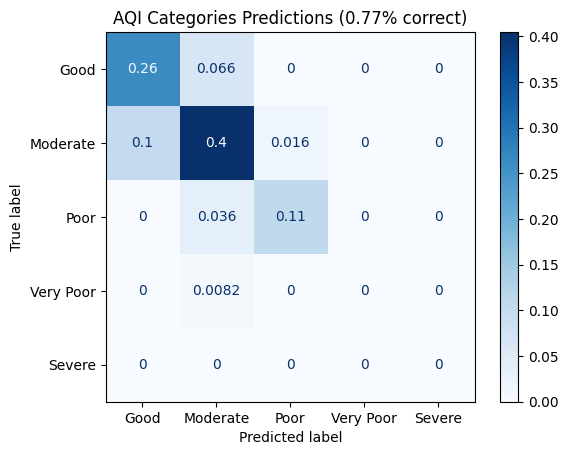

---------------------------------------------
> Absolute Mean AQI Difference: 11.87
> Positive Average AQI Difference: 9.57
> Negative Average AQI Difference: -13.63
> Percentage of Positive Differences: 43.44%
> Percentage of Negative Differences: 56.56%
> Percentage of Agent Values:
   - Same agent: 89.89
   - Different agents: 10.11


In [25]:
station = 'VIA CHIARINI'
print('=============================================')
print(f'Station {station}')
print('=============================================')
print_AQI_category_comparison(pred_AQI_daily[station],true_AQI_daily[station], categories=categories)
print('---------------------------------------------')
print_AQI_difference_metrics(AQI_diff_daily[station])
print('=============================================')